# Model Building

**Overview:** This notebook goes through model building.

Specifically, we'll be walking through:

1. **Data Preparation:** In this case, the data is stored in an SQL table
2. **Model Selection:** Visualizing the data to understand the distribution and correlation of different
3. **Building Final Model:** Retraining the selected model and saving it for later use

The output of this notebook will be clean, organized data stored as a serialized (pickled) dataframe.

**Problem Statement**
Build a predictive model that assigns default probabilities to loan applications and it is similar to what our credit modeling team is doing. Predict the probability that a customer is going to default (target=1) or not (target=0).

**Assumption:** The dataset provided contains credit and loan information about users and whether they have defaulted or not.

## Problem Statement

Build a predictive model that assigns default probabilities to loan applications and it is similar to what our credit modeling team is doing. Predict the probability that a customer is going to default (target=1) or not (target=0).

**Assumption:** The dataset provided contains credit and loan information about users and whether they have defaulted or not.

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve

## Data Preparation

In [2]:
with open("clean_df.pkl", "rb") as file:
    clean_df = pickle.load(file)
    
clean_df.head()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,...,inquiries_count,credit_used_blanco,payment_remarks_amount,e_mal_active_amount,a_mal_active_amount,blanco_amount,credit_card_amount,big_city,loan_type,target
0,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,214302.0,...,8.0,132302.0,0.0,0.0,0.0,132302.0,71778.0,False,pos,1.0
1,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,367.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,pos,0.0
2,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,585991.0,...,46.0,541885.0,0.0,0.0,0.0,541885.0,12792.0,False,blanco-,1.0
3,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,336012.0,...,45.0,251012.0,0.0,0.0,0.0,251012.0,64879.0,False,pos,1.0
4,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,1033.0,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,False,pos,1.0


### Standardize data types

In [3]:
clean_df["has_spouce"] = clean_df["has_spouce"].astype(int)
clean_df["big_city"] = clean_df["big_city"].astype(int)
clean_df["target"] = clean_df["target"].astype(int)

clean_df.head()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,...,inquiries_count,credit_used_blanco,payment_remarks_amount,e_mal_active_amount,a_mal_active_amount,blanco_amount,credit_card_amount,big_city,loan_type,target
0,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,214302.0,...,8.0,132302.0,0.0,0.0,0.0,132302.0,71778.0,0,pos,1
1,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,367.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,pos,0
2,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,585991.0,...,46.0,541885.0,0.0,0.0,0.0,541885.0,12792.0,0,blanco-,1
3,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,336012.0,...,45.0,251012.0,0.0,0.0,0.0,251012.0,64879.0,0,pos,1
4,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,1033.0,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0,pos,1


### One-hot encoding

In [4]:
loan_dummies = pd.get_dummies(clean_df["loan_type"])
loan_dummies.drop(columns=["cc"], inplace=True)
final_df = pd.concat([clean_df, loan_dummies], axis="columns")
final_df.drop(columns=["loan_type"], inplace=True)
final_df.head()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,...,e_mal_active_amount,a_mal_active_amount,blanco_amount,credit_card_amount,big_city,target,blanco,blanco-,cc+,pos
0,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,214302.0,...,0.0,0.0,132302.0,71778.0,0,1,0,0,0,1
1,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,367.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,585991.0,...,0.0,0.0,541885.0,12792.0,0,1,0,1,0,0
3,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,336012.0,...,0.0,0.0,251012.0,64879.0,0,1,0,0,0,1
4,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,1033.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,1


In [5]:
# Selecting features by hand
#final_df = final_df[["external_score", "income_gross", "credit_card_amount", "big_city", "target", "blanco", "blanco-", "cc+", "pos"]]

### Splitting Data

In [6]:
X = final_df.loc[:, final_df.columns != 'target']
y = final_df.loc[:, final_df.columns == 'target']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#columns = X_train.columns

## Model Selection 

In [7]:
def get_score(model, X_train, y_train, X_test, y_test):
    
    # Train & Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    name = type(model).__name__
    
    return {"Sensitivity": sensitivity, "Precision": precision, "Accuracy": accuracy, "Classifier": name}

In [8]:
def compare_classifiers(models, X, y):

    metrics = pd.DataFrame(columns=["Sensitivity", "Precision", "Accuracy", "Classifier"])

    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):

        # Split Data
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        # Over-sample
        smt = SMOTE(random_state=0)
        smt_data_X, smt_data_y = smt.fit_sample(X_train, y_train.values.ravel())

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            
            for model in models:   
                # Train and Evaluate models
                metrics = metrics.append(get_score(model, smt_data_X, smt_data_y, X_test, y_test), ignore_index=True)


    return metrics.groupby("Classifier")["Accuracy", "Sensitivity", "Precision"].mean()

In [9]:
models = [RandomForestClassifier(n_estimators=40), LogisticRegression(), SVC(), DecisionTreeClassifier(), GaussianNB()]
metrics = compare_classifiers(models, X, y)
metrics

,Accuracy,Sensitivity,Precision
Classifier,,,
DecisionTreeClassifier,0.834720,0.770070,0.766938
GaussianNB,0.692822,0.145318,0.900794
LogisticRegression,0.849804,0.781915,0.797111
RandomForestClassifier,0.872311,0.807386,0.828876
SVC,0.388999,0.993555,0.362983


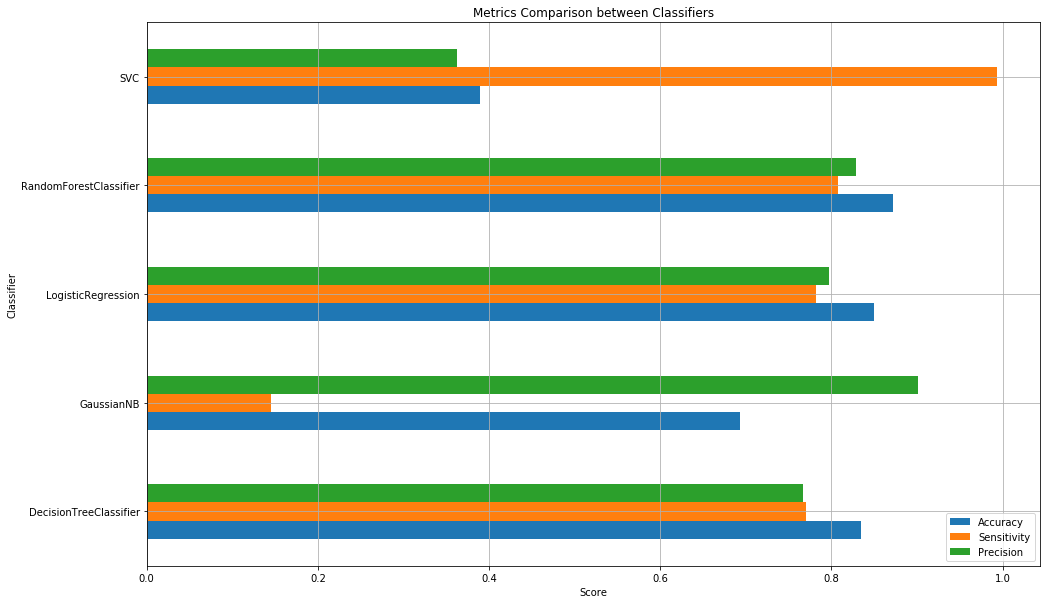

In [10]:
fig, ax = plt.subplots(figsize=(16,10))
metrics.plot(kind='barh', ax=ax)
plt.title("Metrics Comparison between Classifiers")
plt.xlabel("Score")
ax.grid()
plt.savefig("class_comp.png", dpi=150)

**Observations:** Since our goal is to optimize our model for sensitivity (more accurately predict defaults), it seems like the best algorithm would be the RandomForestClassifier. It has a high sensitivity and an even higher precision score, and since both scores are inversely related, improving the sensitivity will still leave us with a decent precision score, giving us a good model overall. SVC has an almost perfect sensitivity score, but a very low precision score. This probably means that there is some bias and that it won't do a good job generalizing. Although we care about accurately predicting defaults, we don't want this to have a huge effect on our ability to accurately predict no defaults (acquire new customers).

In [11]:
algos = [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier()]

dt_params = {'decisiontreeclassifier__min_samples_split' : range(10,500,20),'decisiontreeclassifier__max_depth': range(1,20,2)}
svc_params = {"svc__C": [1, 10, 100, 1000], "svc__kernel": ['linear']}
rfc_params = {"randomforestclassifier__n_estimators": [40, 60, 80, 100, 150, 200]}
lr_params = {"logisticregression__C":np.logspace(-3,3,7), "logisticregression__penalty":["l1","l2"]}

param_grids = [rfc_params, lr_params, dt_params]

best_params = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for algo, param_grid in zip(algos, param_grids):
        
        # Pipeline to do Over-sampling (SMOTE) within the Cross Validation and not before
        pipeline = make_pipeline(SMOTE(), algo)
    
        # Hyperparemeter Tuning
        grid_search = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=10, n_jobs=-1)
        best_params.append(grid_search.fit(X, y))


In [12]:
for mod in best_params:
    print(mod.best_params_)

{'randomforestclassifier__n_estimators': 150}
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
{'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__min_samples_split': 110}


In [22]:
models = [RandomForestClassifier(n_estimators=150), LogisticRegression(C=1.0, penalty='l1'), DecisionTreeClassifier(max_depth=1, min_samples_split=110)]
metrics = compare_classifiers(models, X, y)
metrics

,Accuracy,Sensitivity,Precision
Classifier,,,
DecisionTreeClassifier,0.877297,0.782163,0.857092
LogisticRegression,0.875672,0.814239,0.830503
RandomForestClassifier,0.882318,0.823843,0.836784


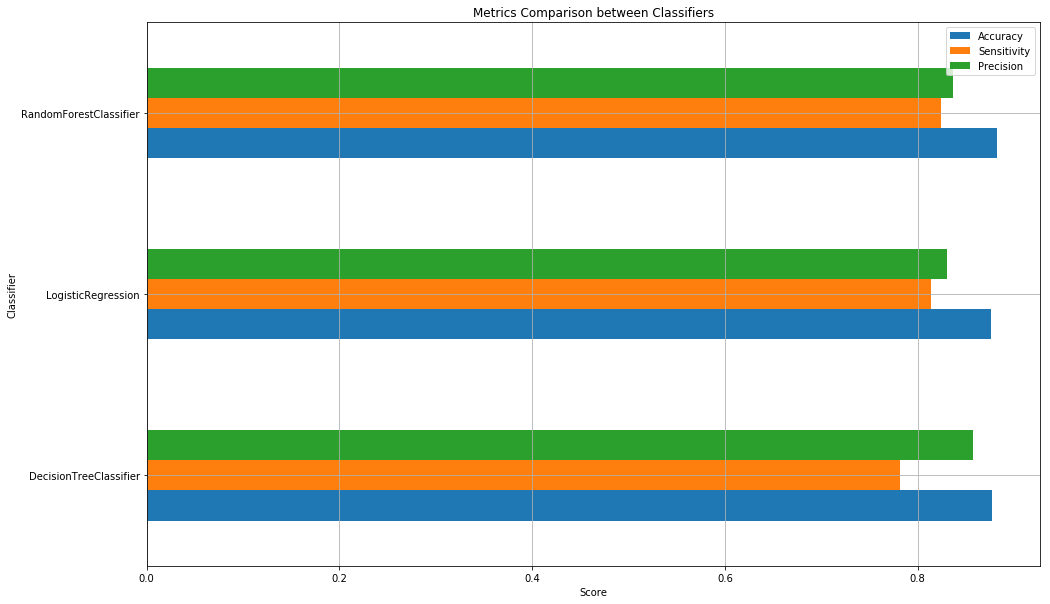

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
metrics.plot(kind='barh', ax=ax)
plt.title("Metrics Comparison between Classifiers")
plt.xlabel("Score")
ax.grid()
plt.savefig("class_comp_tuned.png", dpi=150)

**Observations:** After finetuning our hyperparameters, it seems that Random Forest classifier is still the best choice. Further feature selection should be able to improve the accuracy even more.

In [24]:
def plot_cv_roc_curve(model, X, y):

    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):

        # Split Data
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        # Over-sample
        smt = SMOTE(random_state=0)
        smt_data_X, smt_data_y = smt.fit_sample(X_train, y_train.values.ravel())

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve Classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

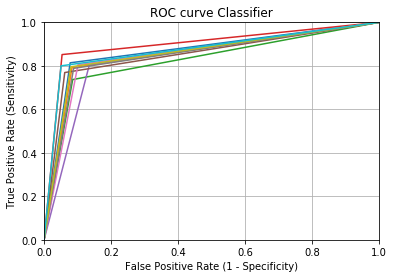

In [26]:
plot_cv_roc_curve(RandomForestClassifier(n_estimators=150), X,y)

## Building Final Model

In [27]:
final_model = RandomForestClassifier(n_estimators=150)
final_model.fit(X, y.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
with open("loan_default_predictor.pkl", "wb") as file:
    pickle.dump(final_model, file)

In [29]:
#with open("loan_default_predictor.pkl", "rb") as file:
    #loan_default_predictor = pickle.load(file)